In [1]:
from hcipy import *

import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
import time
import os

from progressbar import progressbar 
from FFMpegWriter import FFMpegWriter


# from SamDeformableMirror import make_gaussian_influence_functions
%matplotlib inline

# conda install -n <env_name> <package> for installing packages 
# virtual environment

## Setting up the pupil

In [2]:
telescope_diameter = 2.4 # meter
central_obscuration = 0.4 # meter
central_obscuration_ratio = central_obscuration / telescope_diameter
spider_width = 0.01 # meter

# oversizing_factor = 16 / 15
num_pupil_pixels = 240 
pupil_grid_diameter = telescope_diameter #* oversizing_factor  
#why oversize? prevent aliasing, think of it as "padding" the edges
pupil_grid = make_pupil_grid(num_pupil_pixels, pupil_grid_diameter)

aperture_generator = make_obstructed_circular_aperture(telescope_diameter,
    central_obscuration_ratio, num_spiders=4, spider_width=spider_width)

aperture = evaluate_supersampled(aperture_generator, pupil_grid, 4)
# renders the aperture at 4x resolution before downsampling to prevent aliasing

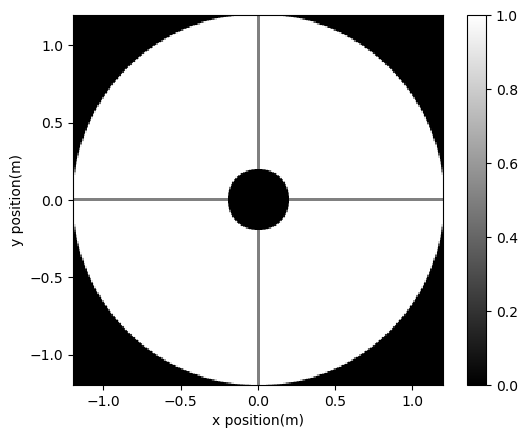

In [3]:
imshow_field(aperture, cmap='gray')
plt.xlabel('x position(m)')
plt.ylabel('y position(m)')
plt.colorbar()
plt.show()

## Generate wavefront from guidestar

should wavelength_sci be different?

In [4]:
wavelength_wfs = 0.632e-6 
wavelength_sci = 0.6e-6 # scientific camera wavelength

wf = Wavefront(aperture, wavelength_sci)
wf.total_power = 1

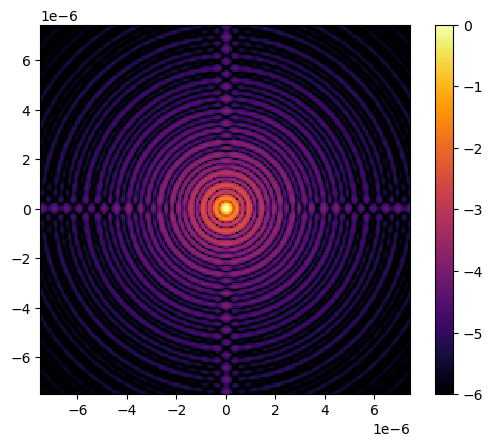

In [5]:
#checking the PSF in ideal telescope performance (make sure wavefront is set up correctly)
# scientific camera
spatial_resolution = wavelength_sci / telescope_diameter #arcsec
focal_grid = make_focal_grid(q=4, num_airy=30, spatial_resolution=spatial_resolution)
# q=4 means 4 pixels per spatial resolution element (lambda/D)
propagator = FraunhoferPropagator(pupil_grid, focal_grid)

unaberrated_PSF = propagator.forward(wf).power

imshow_field(np.log10(unaberrated_PSF / unaberrated_PSF.max()), cmap='inferno', vmin=-6)
plt.colorbar()
plt.show()

## Set up AO & Wavefront Sensor

### Wavefront Sensor (SH)

change up the subapertures for the DM ("How many portions of the wavefront you measure."). 

For a SH system, lenslet array sits in the pupil plane. Each small lenslet samples a small portion (subaperture) of the telescope’s incoming wavefront. This produces an array of spots on a detector; by measuring the spot displacements, the system infers the local slope (tilt) of the wavefront in each subaperture.

- num of pix ~ no. of subapertures
- keep lenslet diameter & focal length the same

In [6]:
f_number = 5.2/.146 #focal length/lenslet lens size
# f_number = 200
# focal length of a lenslet/diameter of a lenslet
num_lenslets = 15 # 15 lenslets along one diameter
sh_diameter = 0.005 #pupil_grid/num_lenslets  #2.4/15 # m (that's the telescope diameter / actuators on one side)
print (sh_diameter)
magnification = sh_diameter / telescope_diameter
magnifier = Magnifier(magnification)

0.005


what i learned: if i decrease the f_number too much (<<500), each lenslet gets oversaturated and the PSF is a mess, unable to correct...which makes sense

In [7]:
shwfs = SquareShackHartmannWavefrontSensorOptics(pupil_grid.scaled(magnification), f_number, \
                                                 num_lenslets, sh_diameter)
shwfse = ShackHartmannWavefrontSensorEstimator(shwfs.mla_grid, shwfs.micro_lens_array.mla_index)

Check with camera

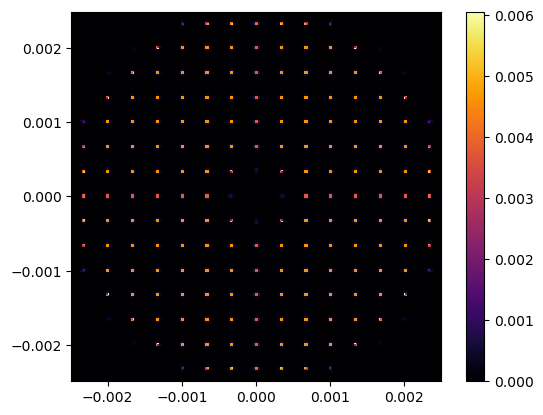

In [8]:
camera = NoiselessDetector(focal_grid)
wf = Wavefront(aperture, wavelength_wfs)
camera.integrate(shwfs(magnifier(wf)), 1)

image_ref = camera.read_out()

imshow_field(image_ref, cmap='inferno')
plt.colorbar()
plt.show()

### Deformable Mirror & Actuators


- put a pattern of zernike modes on the DM to build an interaction matrix
- get a range of the peak and valley of the actuator amplitudes for each correction
- test out the pattern of how the actuators are set up (How many “control points” you can shape or deform to correct the wavefront.)

~~if you get to the part where you're testing the spread of the actuators, play with the label_actuator_centroid_positions in the HCIPy DM class~~

there is a hexagonal grid in hcipy

In [9]:
num_modes = 90
# # 60 Zernike modes

# dm_modes = make_disk_harmonic_basis(pupil_grid, num_modes, telescope_diameter, 'neumann')
# dm_modes = ModeBasis([mode / np.ptp(mode) for mode in dm_modes], pupil_grid)

# deformable_mirror = SamDeformableMirror(dm_modes)


from SamDeformableMirror import make_gaussian_influence_functions
# from SamDeformableMirror import make_gaussian_influence_functions
# influence_functions = make_gaussian_influence_functions(pupil_grid, 15, .16)
# where did we get .16 for actuator spacing from? is it from diameter/num_lenslets?


# influence_functions = make_gaussian_influence_functions(pupil_grid, num_rings=5,
#                                                         crosstalk=0.3,
#                                                         points_first_ring=6, actuator_spacing=0.3)

influence_functions = make_gaussian_influence_functions(pupil_grid, triangle_layout=True, 
                                                        circular_layout=False, num_rings=6,
                                                        points_first_ring=9, crosstalk=0.2,
                                                        actuator_spacing=0.25)

# we can make another shape that is a combo of more equilateral triangles (hexagonal)
from SamDeformableMirror import SamDeformableMirror

deformable_mirror = SamDeformableMirror(influence_functions)
print (len(deformable_mirror.actuators))
print (deformable_mirror.input_grid)


/opt/homebrew/anaconda3/envs/hcipy_env/lib/python3.10/site-packages/hcipy/field/grid.py:107: UserWarning: No automatic weights could be calculated for this grid.
  if np.isscalar(self.weights):


127
CartesianGrid(RegularCoords)


- change the circular influence function's actuator_spacing to be reflective in meters instead of radians (we want like ~22mm between the rings and between act within the rings)
 - they create a (num_actuators_across_pupil)x(num_actuators_across_pupil) grid before they start creating the actuator layout.  



# Math Behind Actuator Layout and Gaussian Influence Functions

In our design, we distribute actuators in concentric rings with a center point. We then apply tilts and a rotation to match the real-world deformable mirror (DM) setup, and finally define Gaussian influence functions for the actuators.

## 1. Actuator Layout

### Radial Position of Each Ring

The radial position for ring *i* is given by

$$
r_i = i \cdot \text{actuator\_spacing}
$$

where:
- i = 1, 2, ... num_rings
- **actuator_spacing** is the gap between successive rings.

### Number of Actuators per Ring

- For the first ring, we have a specified number:
  
  $$
  N_1 = \text{points\_first\_ring}
  $$

- For subsequent rings, the number increases linearly:

  $$
  N_i = i \cdot \text{points\_first\_ring} \quad \text{for } i > 1.
  $$

### Angular Positioning

For a ring with \( N_i \) actuators, the basic angular positions (without offset) would be

$$
\theta_{i,j} = \frac{2\pi j}{N_i}, \quad j = 0, 1, \dots, N_i-1.
$$

To interleave the actuators with those from the previous ring (particularly for even-numbered rings), an offset is applied:

$$
\theta_{i,j} = \frac{\pi}{N_i} + \frac{2\pi j}{N_i} \quad \text{if } i \text{ is even.}
$$

### Cartesian Coordinates

Each actuator’s Cartesian coordinates before applying any tilts are computed as

$$
x_{i,j} = r_i \cos(\theta_{i,j})
$$

$$
y_{i,j} = r_i \sin(\theta_{i,j}).
$$

## 2. Gaussian Influence Functions

Each actuator's influence is modeled with a Gaussian profile:

$$
G(x, y) = \exp\left( -\frac{x^2 + y^2}{2\sigma^2} \right).
$$

### Determining $ \sigma $

The parameter $ \sigma $ is chosen so that the Gaussian has a prescribed value (the **crosstalk**) at a distance equal to the actuator spacing. That is, we require

$$
G(\text{actuator\_spacing}) = \exp\left( -\frac{\text{actuator\_spacing}^2}{2\sigma^2} \right) = \text{crosstalk}.
$$

Taking the natural logarithm of both sides:

$$
-\frac{\text{actuator\_spacing}^2}{2\sigma^2} = \ln(\text{crosstalk}),
$$

which leads to

$$
\sigma = \frac{\text{actuator\_spacing}}{\sqrt{-2\ln(\text{crosstalk})}}.
$$

### Cutoff Distance

The influence function is truncated beyond a certain cutoff. We define a cutoff in units of the actuator spacing relative to \($ \sigma $):

$$
\text{cutoff\_value} = \frac{\text{actuator\_spacing}}{\sigma} \times \text{cutoff}.
$$


## Triangle Math (To be edited)

In this layout, actuators are placed in concentric rings that form equilateral triangles. In order to interleave the layers, the actuator positions in alternate rings are shifted so that they lie in between the actuators of the previous layer.

## 1. Basic Triangle Ring Without Interleaving

For a given ring \( r \) (with \( r=1,2,\dots \)):

- **Side Length:**  
  The side length of the equilateral triangle is:
  \[
  L = r \cdot \text{actuator\_spacing}
  \]
  
- **Total Perimeter:**  
  Since an equilateral triangle has 3 sides, its perimeter is:
  \[
  P = 3L = 3r \cdot \text{actuator\_spacing}
  \]

- **Number of Actuators:**  
  We place actuators evenly along the perimeter. For the basic layout, the total number of actuators in ring \( r \) is:
  \[
  N_r = 3r
  \]
  (This assumes the simplest case where the first ring has 3 actuators, one at each vertex. In a generalized case, you could have a multiple of 3.)

- **Positioning Without Interleaving:**  
  Actuators are placed at distances along the perimeter given by:
  \[
  d_j = j \cdot \text{actuator\_spacing}, \quad j = 0, 1, \dots, N_r-1.
  \]
  
  Each distance \( d_j \) is then mapped onto the triangle edges.

## 2. Mapping Perimeter Distance to Cartesian Coordinates

For an actuator at a distance \( d \) along the perimeter:

1. **Determine the Edge:**  
   The edge index is:
   \[
   e = \left\lfloor \frac{d}{L} \right\rfloor \quad \text{with } e \in \{0,1,2\}.
   \]
   
2. **Local Fraction Along the Edge:**  
   The fraction along the chosen edge is:
   \[
   t = \frac{d \mod L}{L}.
   \]
   
3. **Linear Interpolation:**  
   Let the vertices of the triangle be \(\mathbf{v}_0\), \(\mathbf{v}_1\), and \(\mathbf{v}_2\). If \( e = 0 \), the actuator lies between \(\mathbf{v}_0\) and \(\mathbf{v}_1\); if \( e = 1 \), between \(\mathbf{v}_1\) and \(\mathbf{v}_2\); if \( e = 2 \), between \(\mathbf{v}_2\) and \(\mathbf{v}_0\). Its Cartesian coordinates are given by:
   \[
   \mathbf{p} = (1-t)\mathbf{v}_e + t\,\mathbf{v}_{(e+1) \mod 3}.
   \]

## 3. Introducing Interleaving Between Layers

To interleave the layers (i.e., to have actuators in one ring positioned in between those of the previous ring), we add an **offset** to the distance \( d \) for alternate rings.

- **Offset Definition:**  
  We define the offset \(\Delta\) as:
  \[
  \Delta = 
  \begin{cases}
  0, & \text{if } r \text{ is odd},\\[1ex]
  \frac{\text{actuator\_spacing}}{2}, & \text{if } r \text{ is even}.
  \end{cases}
  \]
  
- **Modified Perimeter Distance:**  
  With interleaving, the distance for the \( j \)-th actuator in ring \( r \) becomes:
  \[
  d_j = j \cdot \text{actuator\_spacing} + \Delta.
  \]
  This shift guarantees that, for even-numbered rings, actuators fall halfway between the positions that would have been defined without an offset. In other words, the actuators in even rings are interleaved with those in the odd rings.

## 4. Summary of the Actuator Position Calculation

For each ring \( r \):

1. Compute the side length:
   \[
   L = r \cdot \text{actuator\_spacing}.
   \]
2. Set the number of actuators:
   \[
   N_r = 3r.
   \]
3. Determine the offset:
   \[
   \Delta = \begin{cases}
   0, & \text{if } r \text{ is odd},\\[1ex]
   \frac{\text{actuator\_spacing}}{2}, & \text{if } r \text{ is even}.
   \end{cases}
   \]
4. For each actuator \( j \) (where \( j=0,1,\dots, N_r-1 \)):
   - Calculate:
     \[
     d_j = j \cdot \text{actuator\_spacing} + \Delta.
     \]
   - Find the edge index:
     \[
     e = \left\lfloor \frac{d_j}{L} \right\rfloor.
     \]
   - Determine the fraction along the edge:
     \[
     t = \frac{d_j \mod L}{L}.
     \]
   - Map to Cartesian coordinates:
     \[
     \mathbf{p} = (1-t)\mathbf{v}_e + t\,\mathbf{v}_{(e+1) \mod 3}.
     \]
5. Finally, apply any required tilts or rotations to align with the real-world setup.

This approach ensures that the layers of actuators in the triangular layout are interleaved, meaning the actuators in even-numbered rings are shifted relative to those in odd-numbered rings, leading to a more uniform and interleaved arrangement.

Feel free to adjust the offset rule (e.g., use interleaving for every ring beyond the first) to suit your specific application.


# Gaussian influence Cross Section

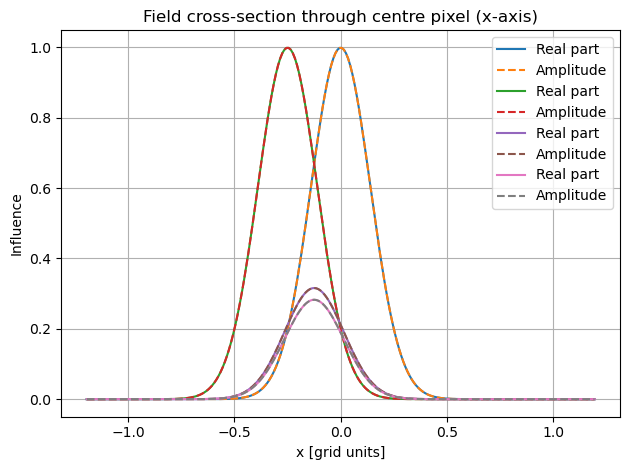

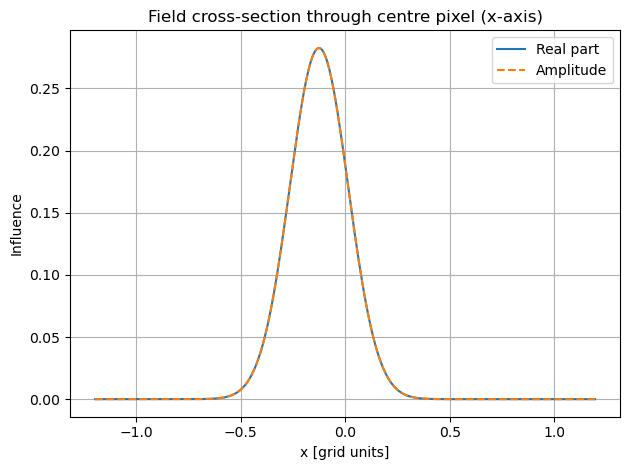

In [10]:
def plot_field_cross_section(field_mode, pupil_grid, axis='x'):
    """
    Plot a 1‑D cross‑section of a single HCIPy Field (one mode of a ModeBasis)
    through the centre row (axis='x') or centre column (axis='y').
    """

    x_flat, y_flat = pupil_grid.x, pupil_grid.y       # 1‑D, length = N
    n_side = int(np.sqrt(x_flat.size))                # assumes square grid

    x2d = x_flat.reshape(n_side, n_side)
    y2d = y_flat.reshape(n_side, n_side)

    values2d = np.asarray(field_mode).reshape(n_side, n_side)

    mid = n_side // 2          # centre index

    if axis == 'x':            # horizontal
        coord_vals = x2d[mid, :]          # x along centre 
        slice_vals = values2d[mid, :]     # field along centre 
        xlabel = 'x [grid units]'
    elif axis == 'y':          # vertical
        coord_vals = y2d[:, mid]          # y along centre 
        slice_vals = values2d[:, mid]     # field along centre 
        xlabel = 'y [grid units]'

    plt.plot(coord_vals, slice_vals.real, label='Real part')
    plt.plot(coord_vals, np.abs(slice_vals), '--', label='Amplitude')
    plt.title(f'Field cross‑section through centre pixel ({axis}-axis)')
    plt.xlabel(xlabel)
    plt.ylabel('Influence')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()






for i in range(4):
    plot_field_cross_section(influence_functions[i], pupil_grid, axis='x')
plt.show()
plot_field_cross_section(influence_functions[3], pupil_grid, axis='x')
plt.show()


## Try doing layers and then shifting the layers by a factor of 1/2 side length, you'll get isoceles but you gotta just change the spacing between the layers of the cartesian grid

cartesian grid with √3/2y




# check with circle

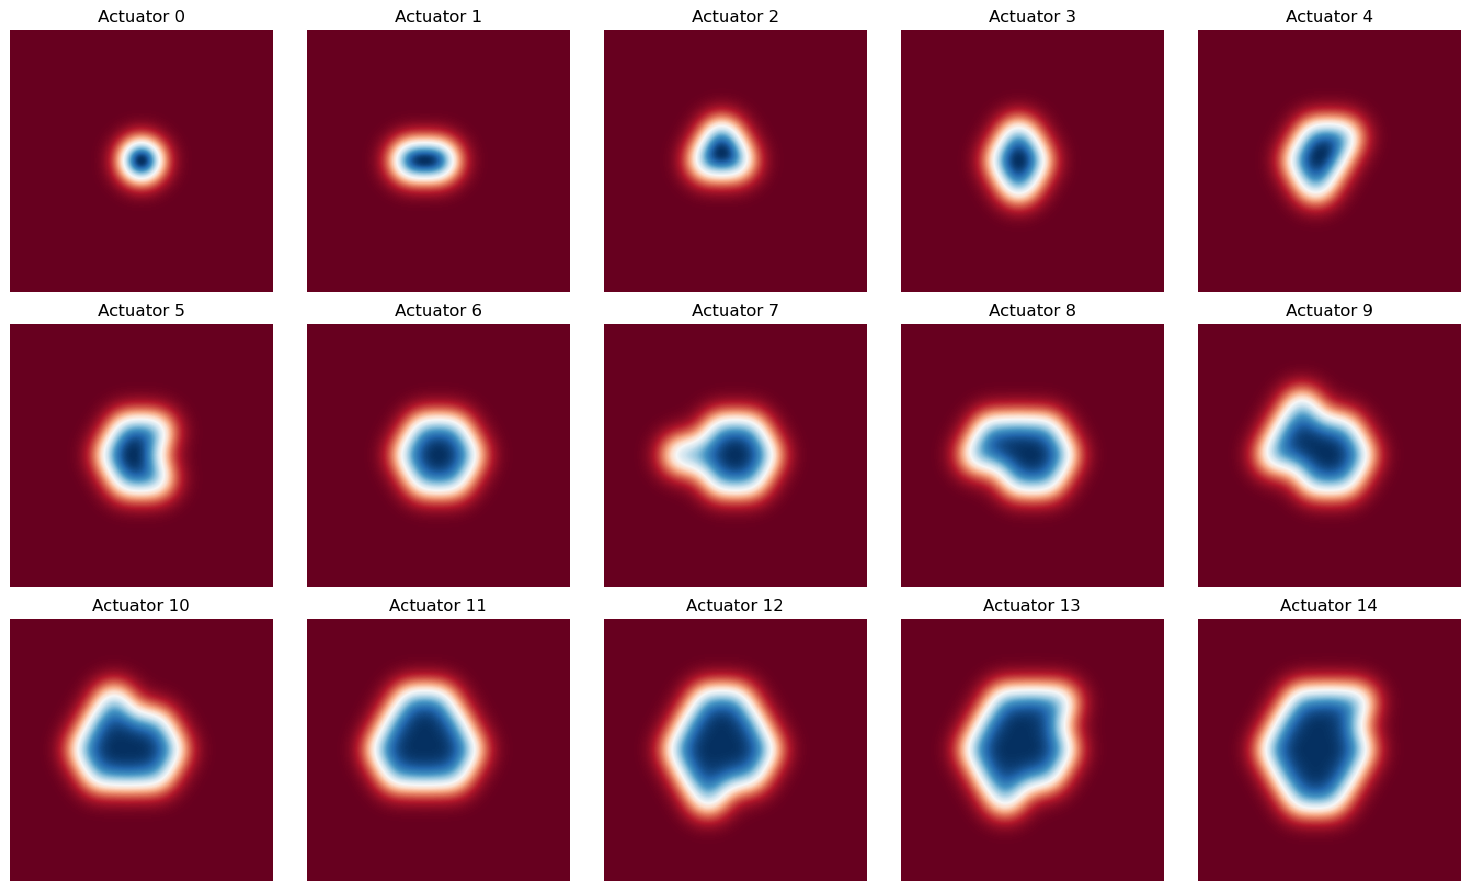

In [11]:
fig, axes = plt.subplots(3, 5, figsize=(15, 9)) 
for i, ax in enumerate(axes.flat):  
    # deformable_mirror.flatten()
    deformable_mirror.actuators[i] = 1

    im = imshow_field(deformable_mirror.surface, cmap='RdBu', ax=ax)
    
    ax.set_title(f'Actuator {i}')
    ax.axis('off') 

fig.tight_layout()
plt.show()

#### Equilateral Triangle Check

Actuator points shape: (127, 2)
NN distance: mean 0.2692610426984774 ± 0.0573227045744692


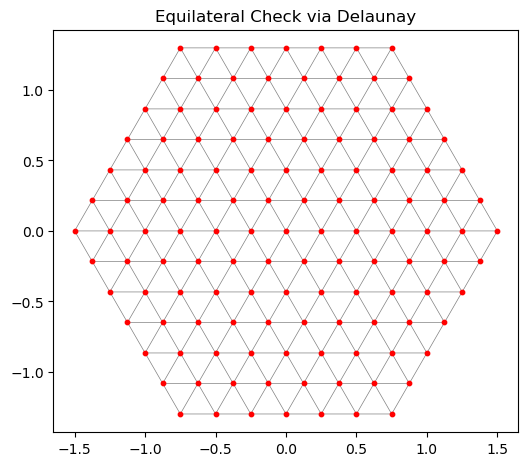

In [12]:
import numpy as np
from scipy.spatial import KDTree, Delaunay
import matplotlib.pyplot as plt

# 1) Generate your triangular grid positions
from SamDeformableMirror import make_triangular_actuator_positions

grid = make_triangular_actuator_positions(num_rings=6, actuator_spacing=0.25)

# 2) Extract an (N,2) array of points
coords = grid.coords           # shape (2, N)
points = np.vstack(coords).T   # now (N, 2)
print("Actuator points shape:", points.shape)

# 3) Ensure enough points
if points.shape[0] < 3:
    raise RuntimeError("Need at least 3 actuator points to do Delaunay triangulation!")

# 4) Do the NN check (optional)
tree = KDTree(points)
dists, _ = tree.query(points, k=7)
print("NN distance: mean", dists[:,1:].mean(), "±", dists[:,1:].std())

# 5) Delaunay triangulation
tri = Delaunay(points)
simplices = tri.simplices

# 6) Plot if you like
plt.figure(figsize=(6,6))
plt.triplot(points[:,0], points[:,1], simplices, color='gray', lw=0.5)
plt.scatter(points[:,0], points[:,1], c='red', s=10)
plt.gca().set_aspect('equal')
plt.title("Equilateral Check via Delaunay")
plt.show()


### Poking Each Actuator

In [13]:
# num_actuators_across_pupil = 10
# actuator_spacing = telescope_diameter / num_actuators_across_pupil
# influence_functions = make_gaussian_influence_functions(pupil_grid, num_actuators_across_pupil, actuator_spacing)
# deformable_mirror = DeformableMirror(influence_functions)
# num_modes = deformable_mirror.num_actuators

anim = FFMpegWriter('dm_surface_animation.mp4', framerate=5)

# Set up the figure for the animation
plt.figure(figsize=(10, 6))

# Loop over the 15 actuators
for i in range(len(deformable_mirror.actuators)):
    # Reset the deformable mirror
    deformable_mirror.flatten()
    # Poke actuator i
    deformable_mirror.actuators[i] = 1

    # Clear the current figure for a new frame
    plt.clf()
    
    # Optional: Add a title to show which actuator is being poked
    plt.suptitle(f'Actuator {i} poked on DM surface')
    
    # Plot the DM surface using HCIPy's imshow_field
    imshow_field(deformable_mirror.surface, cmap='RdBu')
    plt.axis('off')  # Hide axes for a cleaner look
    plt.draw()  # Draw the figure

    # Add the current frame to the animation
    anim.add_frame()

# Close the figure and the animation writer
plt.close()
anim.close()

anim

ffmpeg version 6.1.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with clang version 14.0.6
  configuration: --prefix=/opt/homebrew/anaconda3/envs/hcipy_env --cc=arm64-apple-darwin20.0.0-clang --ar=arm64-apple-darwin20.0.0-ar --nm=arm64-apple-darwin20.0.0-nm --ranlib=arm64-apple-darwin20.0.0-ranlib --strip=arm64-apple-darwin20.0.0-strip --disable-doc --enable-swresample --enable-swscale --enable-openssl --enable-libxml2 --enable-libtheora --enable-demuxer=dash --enable-postproc --enable-hardcoded-tables --enable-libfreetype --enable-libharfbuzz --enable-libfontconfig --enable-libdav1d --enable-zlib --enable-libaom --enable-pic --enable-shared --disable-static --disable-gpl --enable-version3 --disable-sdl2 --enable-libopenh264 --enable-libopus --enable-libmp3lame --enable-libopenjpeg --enable-libvorbis --enable-pthreads --enable-libtesseract --enable-libvpx --enable-librsvg
  libavutil      58. 29.100 / 58. 29.100
  libavcodec     60. 31.102 / 60. 31.102
  libavformat    60. 16

### Zernike Modes on DM

Z[ 0] → min=0.000e+00, max=1.000e+00, examples=OldStyleField([0., 0., 0., 0., 0.])
Z[ 1] → min=-1.992e+00, max=1.992e+00, examples=OldStyleField([-0., -0., -0., -0., -0.])
Z[ 2] → min=-1.992e+00, max=1.992e+00, examples=OldStyleField([-0., -0., -0., -0., -0.])
Z[ 3] → min=-1.732e+00, max=1.731e+00, examples=OldStyleField([0., 0., 0., 0., 0.])
Z[ 4] → min=-2.429e+00, max=2.429e+00, examples=OldStyleField([0., 0., 0., 0., 0.])
Z[ 5] → min=-2.429e+00, max=2.429e+00, examples=OldStyleField([-0., -0., -0., -0., -0.])
Z[ 6] → min=-2.811e+00, max=2.811e+00, examples=OldStyleField([-0., -0., -0., -0., -0.])
Z[ 7] → min=-2.811e+00, max=2.811e+00, examples=OldStyleField([-0., -0., -0., -0., -0.])
Z[ 8] → min=-2.820e+00, max=2.820e+00, examples=OldStyleField([-0., -0., -0., -0., -0.])
Z[ 9] → min=-2.820e+00, max=2.820e+00, examples=OldStyleField([0., 0., 0., 0., 0.])
Z[10] → min=-1.118e+00, max=2.236e+00, examples=OldStyleField([0., 0., 0., 0., 0.])
Z[11] → min=-3.104e+00, max=3.104e+00, examples

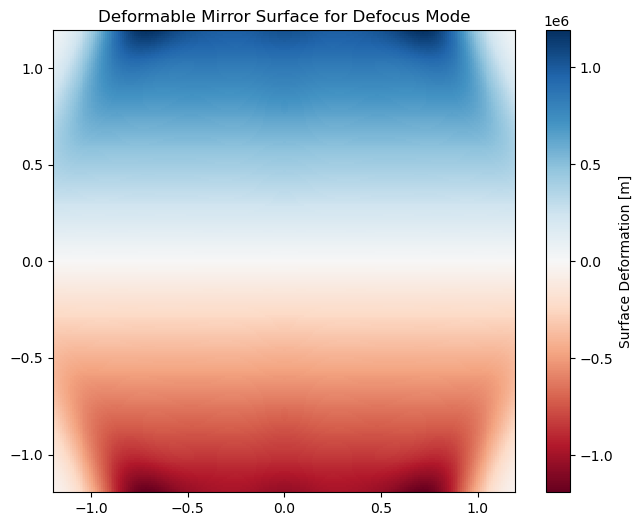

In [14]:


num_actuators = deformable_mirror.num_actuators
poke_amp = 1e-6  # poke amplitude in meters  
pokevec = []
for a in range (num_actuators) :
    amp = np.zeros((num_actuators,))
    amp[a] = poke_amp
    deformable_mirror.actuators = amp
    # wavefront = deformable_mirror.surface * aperture / 2.0
    wavefront = 2 * deformable_mirror.surface * aperture

    pokevec=np.concatenate((pokevec,wavefront),axis=0)          #Create vector first
(numpix,) = np.shape(wavefront)
pokecube = np.reshape(pokevec,(num_actuators,numpix)).T              #reshape to matrix.
deformable_mirror.flatten()

num_modes = 20
zernike_basis = make_zernike_basis(num_modes+1, pupil_grid_diameter, pupil_grid)
# print (len(zernike_basis))

for i, mode in enumerate(zernike_basis):
    flat = mode.ravel()
    print(f"Z[{i:2d}] → min={flat.min():.3e}, max={flat.max():.3e}, "
          f"examples={flat[:5]!r}")



defocus_mode = zernike_basis[6]  

pc = pokecube
pcT =pc.T
pcTxpc = np.dot(pcT, pc )
Transform = np.linalg.solve(pcTxpc, pcT)
actvec = []
for zz in range (1,num_modes+1) :      #Ignore piston
    act = np.dot (Transform,zernike_basis[zz])
    # print ("act:",np.shape(act))
    actvec = np.concatenate((actvec,act),axis = 0)  
    # print ("actvec", np.shape(actvec))        
Mode2Act = np.reshape(actvec,(num_modes,num_actuators)).T

defocus_actuators = Mode2Act[:, 1]

deformable_mirror.actuators = defocus_actuators

plt.figure(figsize=(8, 6))
plt.title('Deformable Mirror Surface for Defocus Mode')
imshow_field(deformable_mirror.surface, cmap='RdBu')  # Adjust vmin/vmax as needed
plt.colorbar(label='Surface Deformation [m]')
plt.show()





## to-do

get the number from the influence function from phil (should be ~0.3m), what is that in terms of sigma? Look at rachel's paper  https://arxiv.org/abs/2110.01693

look at the crosstalk value and make sure you can plot the actuator positions to make sure that you're actually "widening" them. maybe plot like 3 successive actuators to see where they intersect

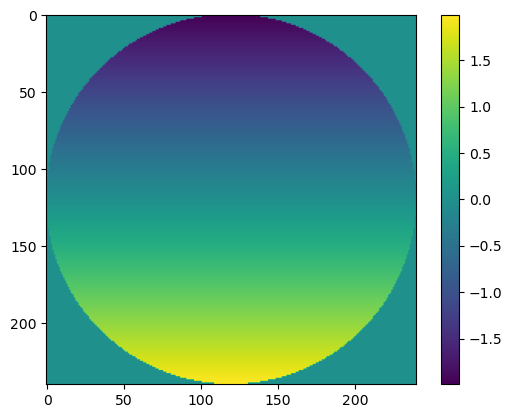

In [15]:
plt.imshow(zernike_basis[2].shaped)
plt.colorbar()

We want to make this into a Zernike modes because we can compare apples-to-apples for the patterns in terms of for example, how well they can compare to the first 50 Zernike modes

In [16]:
for j in range(1, num_modes+1):  # skip piston (j=0)
    # find actuator weights that reproduce Zernike j
    a_j = np.dot(Transform,zernike_basis[j])
    Mode2Act[:, j-1] = a_j

# Loop over Zernike modes to build the interaction (response) matrix 
probe_amp = 0.01 * wavelength_wfs   
response_matrix = []

# set up animation writer
plt.figure(figsize=(10, 6))
anim = FFMpegWriter('response_matrix_zernike.mp4', framerate=5)

# excite each Zernike mode with ±probe_amp
for m in progressbar(range(num_modes)):
    slope = 0

    # get the unit actuator shape for Zernike m
    mode_act = Mode2Act[:, m]

    for sign in (-1, +1):
        deformable_mirror.flatten()
        deformable_mirror.actuators = sign * probe_amp * mode_act

        # propagate and sense
        dm_wf  = deformable_mirror.forward(wf)
        wfs_wf = shwfs(magnifier(dm_wf))
        camera.integrate(wfs_wf, 1)
        image = camera.read_out()

        slopes = shwfse.estimate([image])
        slope += sign * slopes / np.var([-probe_amp, +probe_amp])

    response_matrix.append(slope.ravel())

    # only animate the first 40 modes, then every 20th thereafter
    if m <= 40 or (m+1) % 20 == 0:
        plt.clf()
        plt.suptitle(f'Zernike Mode {m+1}/{num_modes}')

        # DM surface
        plt.subplot(1,2,1)
        plt.title('DM Surface')
        im1 = imshow_field(deformable_mirror.surface, cmap='RdBu', mask=aperture)
        plt.colorbar()

        # SH spots + quiver
        plt.subplot(1,2,2)
        plt.title('SH Spots & Slopes')
        im2 = imshow_field(image)
        quiv = plt.quiver(
            shwfs.mla_grid.subset(shwfse.estimation_subapertures).x,
            shwfs.mla_grid.subset(shwfse.estimation_subapertures).y,
            slope[0,:], slope[1,:],
            color='white'
        )

        anim.add_frame()

# finalize
response_matrix = ModeBasis(response_matrix)  
plt.close()
anim.close()

anim


ffmpeg version 6.1.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with clang version 14.0.6
  configuration: --prefix=/opt/homebrew/anaconda3/envs/hcipy_env --cc=arm64-apple-darwin20.0.0-clang --ar=arm64-apple-darwin20.0.0-ar --nm=arm64-apple-darwin20.0.0-nm --ranlib=arm64-apple-darwin20.0.0-ranlib --strip=arm64-apple-darwin20.0.0-strip --disable-doc --enable-swresample --enable-swscale --enable-openssl --enable-libxml2 --enable-libtheora --enable-demuxer=dash --enable-postproc --enable-hardcoded-tables --enable-libfreetype --enable-libharfbuzz --enable-libfontconfig --enable-libdav1d --enable-zlib --enable-libaom --enable-pic --enable-shared --disable-static --disable-gpl --enable-version3 --disable-sdl2 --enable-libopenh264 --enable-libopus --enable-libmp3lame --enable-libopenjpeg --enable-libvorbis --enable-pthreads --enable-libtesseract --enable-libvpx --enable-librsvg
  libavutil      58. 29.100 / 58. 29.100
  libavcodec     60. 31.102 / 60. 31.102
  libavformat    60. 16

[############################################################] 20/20


Input #0, image2pipe, from 'fd:':
  Duration: N/A, bitrate: N/A
  Stream #0:0: Video: png, rgba(pc, gbr/unknown/unknown), 1000x600 [SAR 3937:3937 DAR 5:3], 5 fps, 5 tbr, 5 tbn
[out#0/mp4 @ 0x11df04ac0] Codec AVOption crf (Select the quality for constant quality mode) has not been used for any stream. The most likely reason is either wrong type (e.g. a video option with no video streams) or that it is a private option of some encoder which was not actually used for any stream.
Stream mapping:
  Stream #0:0 -> #0:0 (png (native) -> h264 (libopenh264))
[libopenh264 @ 0x11df05bd0] [OpenH264] this = 0x0x10e10ad90, Warning:layerId(0) doesn't support profile(578), change to UNSPECIFIC profile
[libopenh264 @ 0x11df05bd0] [OpenH264] this = 0x0x10e10ad90, Warning:bEnableFrameSkip = 0,bitrate can't be controlled for RC_QUALITY_MODE,RC_BITRATE_MODE and RC_TIMESTAMP_MODE without enabling skip frame.
[libopenh264 @ 0x11df05bd0] [OpenH264] this = 0x0x10e10ad90, Warning:Change QP Range from(0,51) to (

In [17]:
# defocus_actuators = Mode2Act[:, 1]

# deformable_mirror.actuators = defocus_actuators

# plt.figure(figsize=(8, 6))
# plt.title('Deformable Mirror Surface for Defocus Mode')
# imshow_field(deformable_mirror.surface, cmap='RdBu')  # Adjust vmin/vmax as needed
# plt.colorbar(label='Surface Deformation [m]')
# plt.show()

In [18]:
rcond = 1e-3

reconstruction_matrix = inverse_tikhonov(response_matrix.transformation_matrix, rcond=rcond)
print(reconstruction_matrix.shape)

(20, 450)


# Closing the loop w/o atmospheric disturbance
DM set to a random position by setting the DM actuators at random values.

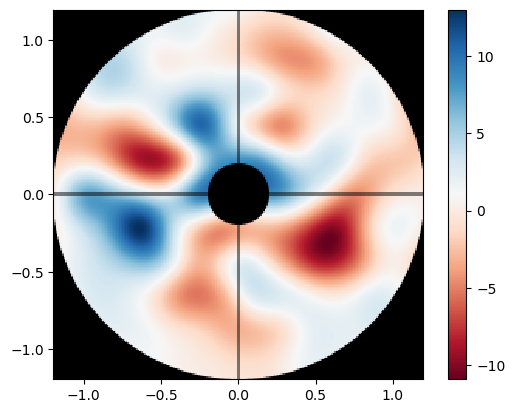

In [19]:
# Put actuators at random values, putting a little more power in low-order positions
n_act = deformable_mirror.num_actuators
deformable_mirror.actuators = np.random.randn(n_act) / (np.arange(n_act) + 10)

# Normalize the DM surface so that we get a reasonable surface RMS.
deformable_mirror.actuators *= 0.3 * wavelength_sci / np.std(deformable_mirror.surface)

imshow_field(deformable_mirror.phase_for(wavelength_wfs), mask=aperture, cmap='RdBu')
plt.colorbar()
plt.show()

In [ ]:
zero_magnitude_flux = 3.9e10 #3.9e10 photon/s for a mag 0 star
delta_t = 1e-3 # sec, so a loop speed of 1kHz.

# flux_for_mag = lambda mag: 100**(-0.2 * (mag)) # simplified Pogson relation
flux_for_mag = lambda mag :zero_magnitude_flux * 10**(-mag / 2.5)
guide_star_mag = 10.0

star_flux = flux_for_mag(guide_star_mag)

wf_wfs = Wavefront(aperture, wavelength_wfs)
wf_wfs.total_power = star_flux
wf_sci = Wavefront(aperture, wavelength_sci)
wf_sci.total_power = star_flux

gain = 0.1
# gain is the proportion of the DM response that is applied to the DM actuators
leakage = 0.01
# leakage is the proportion of the DM response that leaks into the science camera
num_iterations = 200

long_exposure = 0
# print (zero_magnitude_flux * 10**(-guide_star_mag / 2.5))
# print (star_flux)

In [21]:
slopes_ref = shwfse.estimate([image_ref])


In [22]:
# Set up animation
plt.figure(figsize=(8, 8))
anim = FFMpegWriter('AO_simulation_without_turbulence.mp4', framerate=10)

# Compute and store reference slopes on a flat wavefront (same shape as slopes)
# camera.integrate(shwfs(magnifier(deformable_mirror(wf_wfs))), delta_t)
# ref_image = camera.read_out()
# slopes_ref = shwfse.estimate([ref_image])

for timestep in progressbar(range(num_iterations)):
    # Propagate through SH-WFS
    wf_after_sh = shwfs(magnifier(deformable_mirror(wf_wfs)))

    # Propagate the NIR wavefront
    wf_sci_after_dm = propagator(deformable_mirror(wf_sci))

    # Read out WFS camera
    camera.integrate(wf_after_sh, delta_t)
    wfs_image = camera.read_out()
    wfs_image = large_poisson(wfs_image).astype('float')

    # Calculate slopes from WFS image
    slopes = shwfse.estimate([wfs_image + 1e-10])
    slopes -= slopes_ref
    slopes = slopes.ravel()

    # Perform wavefront control and set DM actuators
    # 1) map WFS slopes → Zernike mode coefficients
    mode_commands = reconstruction_matrix.dot(slopes)
    # 2) map those modal commands → actuator pokes
    actuator_update = Mode2Act.dot(mode_commands)
    # 3) apply update with gain & leakage
    deformable_mirror.actuators = (1 - leakage) * deformable_mirror.actuators \
                                  - gain * actuator_update

    # Plotting
    if timestep % 20 == 0:
        plt.clf()
        plt.suptitle('Timestep %d / %d' % (timestep, num_iterations))

        plt.subplot(2,2,1)
        plt.title('DM surface [$\\mu$m]')
        imshow_field(deformable_mirror.surface * 1e6, cmap='RdBu', vmin=-0.5, vmax=0.5, mask=aperture)
        plt.colorbar()

        plt.subplot(2,2,2)
        plt.title('WFS image [counts]')
        imshow_field(wfs_image, cmap='inferno')
        plt.colorbar()

        plt.subplot(2,2,3)
        plt.title('Instantaneous PSF at 2.2$\\mu$m [log]')
        imshow_field(np.log10(wf_sci_after_dm.power / wf_sci_after_dm.power.max()), vmin=-6, vmax=0, cmap='inferno')
        plt.colorbar()

        anim.add_frame()

plt.close()
anim.close()

# Show created animation
anim

ffmpeg version 6.1.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with clang version 14.0.6
  configuration: --prefix=/opt/homebrew/anaconda3/envs/hcipy_env --cc=arm64-apple-darwin20.0.0-clang --ar=arm64-apple-darwin20.0.0-ar --nm=arm64-apple-darwin20.0.0-nm --ranlib=arm64-apple-darwin20.0.0-ranlib --strip=arm64-apple-darwin20.0.0-strip --disable-doc --enable-swresample --enable-swscale --enable-openssl --enable-libxml2 --enable-libtheora --enable-demuxer=dash --enable-postproc --enable-hardcoded-tables --enable-libfreetype --enable-libharfbuzz --enable-libfontconfig --enable-libdav1d --enable-zlib --enable-libaom --enable-pic --enable-shared --disable-static --disable-gpl --enable-version3 --disable-sdl2 --enable-libopenh264 --enable-libopus --enable-libmp3lame --enable-libopenjpeg --enable-libvorbis --enable-pthreads --enable-libtesseract --enable-libvpx --enable-librsvg
  libavutil      58. 29.100 / 58. 29.100
  libavcodec     60. 31.102 / 60. 31.102
  libavformat    60. 16

[############################################################] 200/200


Input #0, image2pipe, from 'fd:':
  Duration: N/A, bitrate: N/A
  Stream #0:0: Video: png, rgba(pc, gbr/unknown/unknown), 800x800 [SAR 3937:3937 DAR 1:1], 10 fps, 10 tbr, 10 tbn
[out#0/mp4 @ 0x10c6041d0] Codec AVOption crf (Select the quality for constant quality mode) has not been used for any stream. The most likely reason is either wrong type (e.g. a video option with no video streams) or that it is a private option of some encoder which was not actually used for any stream.
Stream mapping:
  Stream #0:0 -> #0:0 (png (native) -> h264 (libopenh264))
[libopenh264 @ 0x10c605a60] [OpenH264] this = 0x0x12d8048d0, Warning:layerId(0) doesn't support profile(578), change to UNSPECIFIC profile
[libopenh264 @ 0x10c605a60] [OpenH264] this = 0x0x12d8048d0, Warning:bEnableFrameSkip = 0,bitrate can't be controlled for RC_QUALITY_MODE,RC_BITRATE_MODE and RC_TIMESTAMP_MODE without enabling skip frame.
[libopenh264 @ 0x10c605a60] [OpenH264] this = 0x0x12d8048d0, Warning:Change QP Range from(0,51) to

## Atmospheric turbulence

- set velocity as the independent variable

In [23]:
# seeing = 1.5 #arcsec (r_naught=0.8m)
# seeing = 1.3 #arcsec (r_naught=0.8m)
seeing = 0.5 #arcsec 

outer_scale = 40 # meter
# r0=seeing_to_fried_parameter(seeing)
# print (0.005 * (0.8 / r0))



fried_parameter = seeing_to_fried_parameter(seeing)
# tau0 = 0.0025 # arbitrary, does Lick Observatory have a value?
tau0 = 0.015 # from tutorial
Cn_squared = Cn_squared_from_fried_parameter(fried_parameter, 500e-9)
velocity = 0.314 * fried_parameter / tau0

print('r0   = {0:.1f}cm'.format(fried_parameter * 100))
print('L0   = {0:.1f}m'.format(outer_scale))
print('tau0 = {0:.1f}ms'.format(tau0 * 1000))
print('v    = {0:.1f}m/s'.format(velocity))

r0   = 20.2cm
L0   = 40.0m
tau0 = 15.0ms
v    = 4.2m/s


-2 -2.1436258429871726


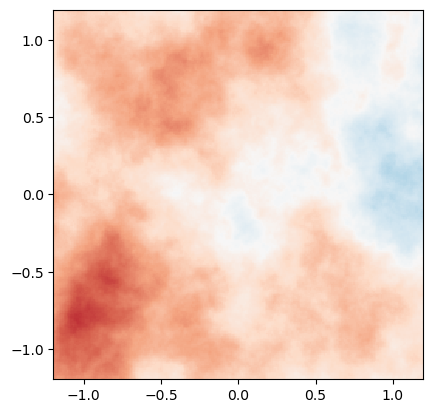

In [24]:
layer = InfiniteAtmosphericLayer(pupil_grid, Cn_squared, outer_scale, velocity)

phase_screen_phase = layer.phase_for(wavelength_wfs) # in radian
phase_screen_opd = phase_screen_phase * (wavelength_wfs / (2 * np.pi)) * 1e6

print(int(np.max(phase_screen_opd)), np.max(phase_screen_opd))
imshow_field(phase_screen_opd, vmin=int(np.min(phase_screen_opd))-1, vmax=np.max(phase_screen_opd)+1, cmap='RdBu')

In [25]:
plt.figure(figsize=(5, 4))
anim = FFMpegWriter('atmospheric_turbulence.mp4', framerate=5)

t_end = 1
n = 51
for t in np.linspace(0, t_end, n):
    layer.t = t

    phase_screen_phase = layer.phase_for(wavelength_wfs) # in radian
    phase_screen_opd = phase_screen_phase * (wavelength_wfs / (2 * np.pi)) * 1e6 # in um

    plt.clf()
    plt.suptitle('Time %.3f s' % t)

    plt.subplot(1,1,1)
    plt.title('Turbulent wavefront [$\\mu$m]')
    imshow_field(phase_screen_opd, vmin=int(np.min(phase_screen_opd))-1, vmax=np.max(phase_screen_opd)+1, cmap='RdBu')
    plt.colorbar()

    anim.add_frame()

plt.close()
anim.close()

# Show created animation
anim

ffmpeg version 6.1.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with clang version 14.0.6
  configuration: --prefix=/opt/homebrew/anaconda3/envs/hcipy_env --cc=arm64-apple-darwin20.0.0-clang --ar=arm64-apple-darwin20.0.0-ar --nm=arm64-apple-darwin20.0.0-nm --ranlib=arm64-apple-darwin20.0.0-ranlib --strip=arm64-apple-darwin20.0.0-strip --disable-doc --enable-swresample --enable-swscale --enable-openssl --enable-libxml2 --enable-libtheora --enable-demuxer=dash --enable-postproc --enable-hardcoded-tables --enable-libfreetype --enable-libharfbuzz --enable-libfontconfig --enable-libdav1d --enable-zlib --enable-libaom --enable-pic --enable-shared --disable-static --disable-gpl --enable-version3 --disable-sdl2 --enable-libopenh264 --enable-libopus --enable-libmp3lame --enable-libopenjpeg --enable-libvorbis --enable-pthreads --enable-libtesseract --enable-libvpx --enable-librsvg
  libavutil      58. 29.100 / 58. 29.100
  libavcodec     60. 31.102 / 60. 31.102
  libavformat    60. 16

# Close loop on sky

In [26]:
layer.reset()
deformable_mirror.flatten()

gain = 0.9
leakage = 0.01
num_iterations = 50
burn_in_iterations = 0

coro = PerfectCoronagraph(aperture, 4)
# wf_wfs = Wavefront(aperture, wavelength_wfs)


long_exposure = focal_grid.zeros()
long_exposure_coro = focal_grid.zeros()

# Set up animation
plt.figure(figsize=(8, 8))
anim = FFMpegWriter('AO_simulation_with_turbulence.mp4', framerate=10)

for timestep in progressbar(range(num_iterations)):
    layer.t = timestep * delta_t

    # Propagate through atmosphere and deformable mirror.
    wf_wfs_after_atmos = layer(wf_wfs)    

    wf_wfs_after_dm = deformable_mirror(wf_wfs_after_atmos)

    # Propagate through SH-WFS
    wf_wfs_on_sh = shwfs(magnifier(wf_wfs_after_dm))

    # Propagate the NIR wavefront
    wf_sci_focal_plane = propagator(deformable_mirror(layer(wf_sci)))
    wf_sci_coro = propagator(coro(deformable_mirror(layer(wf_sci))))

    # Read out WFS camera
    camera.integrate(wf_wfs_on_sh, delta_t)
    wfs_image = camera.read_out()
    wfs_image = large_poisson(wfs_image).astype('float')

    # Accumulate long-exposure image
    if timestep >= burn_in_iterations:
        long_exposure += wf_sci_focal_plane.power / (num_iterations - burn_in_iterations)
        long_exposure_coro += wf_sci_coro.power / (num_iterations - burn_in_iterations)

    # # # Calculate slopes from WFS image
    # norm   = np.var([-probe_amp, +probe_amp])
    # print (norm)
    # # norm = np.var([-1e-6, +1e06])
    # raw    = shwfse.estimate([wfs_image + 1e-10]).ravel()
    # # make sure ref has same flat shape as raw
    # slopes = (raw - slopes_ref.ravel()) / norm


    slopes = shwfse.estimate([wfs_image + 1e-10])
    slopes -= slopes_ref
    slopes = slopes.ravel()

    # 1) map WFS slopes → Zernike mode coefficients
    mode_commands = reconstruction_matrix.dot(slopes)
    print (mode_commands)
    # 2) map those modal commands → actuator pokes
    actuator_update = Mode2Act.dot(mode_commands)
    # print (actuator_update)
    # 3) apply update with gain & leakage
    deformable_mirror.actuators = (1 - leakage) * deformable_mirror.actuators \
                                  - gain * actuator_update

    
    # Inspect actuator commands
    acts = deformable_mirror.actuators
    # print(f"Actuators range: {acts.min():.3e} … {acts.max():.3e} [unitless]")
    # Inspect physical surface (in μm)
    surf = deformable_mirror.surface * 1e6
    # print(f"DM surface height: {surf.min():.3e} … {surf.max():.3e} μm")

    
    # Plotting
    if timestep % 20 == 0:
        print(f"Actuator range: {deformable_mirror.actuators.min()} to {deformable_mirror.actuators.max()}")
        plt.clf()

        plt.suptitle('Timestep %d / %d' % (timestep, num_iterations))

        # wf_wfs = Wavefront(aperture, wavelength_wfs)

        # show current atmospheric phase screen in the animation
        # phase_screen_phase = wf_wfs_after_atmos.phase
        print (wfs_wf)
        # phase_screen_phase = wf_wfs.phase
        phase_screen_phase = layer.phase_for(wavelength_wfs) # in radian
        phase_screen_opd   = phase_screen_phase * (wavelength_wfs / (2 * np.pi)) * 1e6  # in microns
        plt.subplot(2,2,4)
        plt.title('Atmospheric OPD [$\mu$m]')
        imshow_field(phase_screen_opd, cmap='RdBu', mask=aperture)
        plt.colorbar()

        plt.subplot(2,2,1)
        plt.title('DM surface [$\\mu$m]')
        imshow_field(deformable_mirror.surface * 1e6, cmap='RdBu', mask=aperture)
        plt.colorbar()

        plt.subplot(2,2,2)
        plt.title('WFS image [counts]')
        imshow_field(wfs_image, cmap='inferno')
        plt.colorbar()

        plt.subplot(2,2,3)
        plt.title('Instantaneous PSF at 2.2$\\mu$m [log]')
        imshow_field(np.log10(wf_sci_focal_plane.power/ wf_sci_focal_plane.power.max()), vmin=-6, vmax=0, cmap='inferno') #
        plt.colorbar()

        # if timestep >= burn_in_iterations:
        #     plt.subplot(2,2,4)
        #     plt.title('Average PSF at 2.2$\\mu$m [log]')
        #     imshow_field(np.log10(long_exposure_coro / long_exposure.max()), vmin=-6, vmax=0, cmap='inferno')
        #     plt.colorbar()

        anim.add_frame()

plt.close()
anim.close()

# Show created animation
anim

ffmpeg version 6.1.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with clang version 14.0.6
  configuration: --prefix=/opt/homebrew/anaconda3/envs/hcipy_env --cc=arm64-apple-darwin20.0.0-clang --ar=arm64-apple-darwin20.0.0-ar --nm=arm64-apple-darwin20.0.0-nm --ranlib=arm64-apple-darwin20.0.0-ranlib --strip=arm64-apple-darwin20.0.0-strip --disable-doc --enable-swresample --enable-swscale --enable-openssl --enable-libxml2 --enable-libtheora --enable-demuxer=dash --enable-postproc --enable-hardcoded-tables --enable-libfreetype --enable-libharfbuzz --enable-libfontconfig --enable-libdav1d --enable-zlib --enable-libaom --enable-pic --enable-shared --disable-static --disable-gpl --enable-version3 --disable-sdl2 --enable-libopenh264 --enable-libopus --enable-libmp3lame --enable-libopenjpeg --enable-libvorbis --enable-pthreads --enable-libtesseract --enable-libvpx --enable-librsvg
  libavutil      58. 29.100 / 58. 29.100
  libavcodec     60. 31.102 / 60. 31.102
  libavformat    60. 16

[ 2.32250533e-18 -3.02474981e-18 -3.61512377e-18 -5.61789519e-19
  1.62037544e-18  6.32075041e-19 -2.99420593e-19  2.63378414e-18
  1.21185747e-19  4.12355974e-18  4.06634138e-18  1.29195187e-18
 -1.51825866e-17  1.22351267e-18 -2.40373145e-18 -2.87674748e-18
 -4.84784522e-19  1.51411653e-18  2.19286470e-18  1.05561163e-19]
Actuator range: -3.633406690874692e-11 to 3.3532128239925126e-11
[ 2.43857671e-18  3.87406503e-18 -3.27170072e-18  7.65288810e-20/50
  6.13249140e-18 -7.67581095e-19 -4.07760274e-18  1.19949829e-18
  1.33043645e-18  6.84450548e-19  3.68007695e-18  2.03210346e-19
 -1.40899198e-17  3.30213294e-18 -2.98203187e-18 -2.68706478e-18
  2.73855800e-18 -1.52692581e-18  1.80658089e-18  9.98190742e-19]
[ 2.23061493e-18 -2.52654345e-19 -4.22627377e-18 -1.73732104e-18/50
  6.38215431e-18 -2.92472898e-18 -1.58991605e-18  2.59076686e-18
 -3.16977556e-18  5.91547995e-18  2.90483342e-18 -8.04386456e-19
 -1.46113521e-17 -3.58550370e-19 -4.48629508e-18 -4.11826421e-18
 -1.57205354e-18 

Input #0, image2pipe, from 'fd:':
  Duration: N/A, bitrate: N/A
  Stream #0:0: Video: png, rgba(pc, gbr/unknown/unknown), 800x800 [SAR 3937:3937 DAR 1:1], 10 fps, 10 tbr, 10 tbn
[out#0/mp4 @ 0x1197041b0] Codec AVOption crf (Select the quality for constant quality mode) has not been used for any stream. The most likely reason is either wrong type (e.g. a video option with no video streams) or that it is a private option of some encoder which was not actually used for any stream.
Stream mapping:
  Stream #0:0 -> #0:0 (png (native) -> h264 (libopenh264))
[libopenh264 @ 0x1197052d0] [OpenH264] this = 0x0x1196073a0, Warning:layerId(0) doesn't support profile(578), change to UNSPECIFIC profile
[libopenh264 @ 0x1197052d0] [OpenH264] this = 0x0x1196073a0, Warning:bEnableFrameSkip = 0,bitrate can't be controlled for RC_QUALITY_MODE,RC_BITRATE_MODE and RC_TIMESTAMP_MODE without enabling skip frame.
[libopenh264 @ 0x1197052d0] [OpenH264] this = 0x0x1196073a0, Warning:Change QP Range from(0,51) to

In [27]:
# layer.reset()
# deformable_mirror.flatten()

# gain = 0.8
# leakage = 0.01
# num_iterations = 750
# burn_in_iterations = 100

# coro = PerfectCoronagraph(aperture, 4)

# long_exposure = focal_grid.zeros()
# long_exposure_coro = focal_grid.zeros()

In [28]:
# # Set up animation
# plt.figure(figsize=(8, 8))
# anim = FFMpegWriter('AO_simulation_with_turbulence.mp4', framerate=10)
# strehl_ratios = []

# for timestep in progressbar(range(num_iterations)):
#     layer.t = timestep * delta_t

#     # Propagate through atmosphere and deformable mirror.
#     wf_wfs_after_atmos = layer(wf_wfs)
#     wf_wfs_after_dm = deformable_mirror(wf_wfs_after_atmos)

#     # Propagate through SH-WFS
#     wf_wfs_on_sh = shwfs(magnifier(wf_wfs_after_dm))

#     # Propagate the NIR wavefront
#     wf_sci_focal_plane = propagator(deformable_mirror(layer(wf_sci)))
#     wf_sci_coro = propagator(coro(deformable_mirror(layer(wf_sci))))

#     # Read out WFS camera
#     camera.integrate(wf_wfs_on_sh, delta_t)
#     wfs_image = camera.read_out()
#     wfs_image = large_poisson(wfs_image).astype('float')

#     # Accumulate long-exposure image
#     if timestep >= burn_in_iterations:
#         long_exposure += wf_sci_focal_plane.power / (num_iterations - burn_in_iterations)
#         long_exposure_coro += wf_sci_coro.power / (num_iterations - burn_in_iterations)

#     # Calculate slopes from WFS image
#     slopes = shwfse.estimate([wfs_image + 1e-10])
#     slopes -= slopes_ref
#     slopes = slopes.ravel()

#     # Perform wavefront control and set DM actuators
#     # deformable_mirror.actuators = (1 - leakage) * deformable_mirror.actuators - gain * reconstruction_matrix.dot(slopes)
    
#     # 1) map WFS slopes → Zernike mode coefficients
#     mode_commands = reconstruction_matrix.dot(slopes)
#     # 2) map those modal commands → actuator pokes
#     actuator_update = Mode2Act.dot(mode_commands)
#     # 3) apply update with gain & leakage
#     deformable_mirror.actuators = (1 - leakage) * deformable_mirror.actuators \
#                                   - gain * actuator_update
    
#      # Compute the instantaneous Strehl ratio:
#     # Strehl ratio is the ratio of the current PSF's peak to the ideal PSF peak.
#     # current_peak = wf_sci_focal_plane.power.max()
#     # current_strehl = current_peak / ideal_peak
#     # strehl_ratios.append(current_strehl)

#     # Plotting
#     if timestep % 20 == 0:
#         plt.clf()

#         plt.suptitle('Timestep %d / %d' % (timestep, num_iterations))

#         plt.subplot(2,2,1)
#         plt.title('DM surface [$\\mu$m]')
#         imshow_field(deformable_mirror.surface * 1e6, cmap='RdBu', vmin=-2, vmax=2, mask=aperture)
#         plt.colorbar()

#         plt.subplot(2,2,2)
#         plt.title('WFS image [counts]')
#         imshow_field(wfs_image, cmap='inferno')
#         plt.colorbar()

#         plt.subplot(2,2,3)
#         plt.title('Instantaneous PSF at 2.2$\\mu$m [log]')
#         imshow_field(np.log10(wf_sci_focal_plane.power/ wf_sci_focal_plane.power.max()), vmin=-6, vmax=0, cmap='inferno') #
#         plt.colorbar()

#         # Linear PSF plot
#         # plt.subplot(2,2,3)
#         # plt.title('Instantaneous PSF at 2.2')
#         # imshow_field(wf_sci_focal_plane.power/ wf_sci_focal_plane.power.max(), cmap='inferno') #
#         # plt.colorbar()


#         if timestep >= burn_in_iterations:
#             plt.subplot(2,2,4)
#             plt.title('Average PSF at 2.2$\\mu$m [log]')
#             imshow_field(np.log10(long_exposure_coro / long_exposure.max()), vmin=-6, vmax=0, cmap='inferno')
#             plt.colorbar()

#         anim.add_frame()

# plt.close()
# anim.close()

# # plt.figure(figsize=(10, 5))
# # plt.plot(np.arange(num_iterations), strehl_ratios, '-o', markersize=3)
# # plt.xlabel('Iteration')
# # plt.ylabel('Strehl Ratio')
# # plt.title('Strehl Ratio vs. AO Iteration')
# # plt.grid(True)
# # plt.show()

# # Show created animation
# anim



- strehl graph or fwhm
- linear graph for psf as opposed to log (strikethrough) actually use a x^2 graph for a blend of both
- experiment with r0 values

we care about enclosed energy





next steps: 
- WRITE THE INTRODUCTION!!!!!!!
    - for the analysis plots, write about the plots that you'll use, and you'll have to include your lab notebooks
- loop speed vs strehl, for 5 loop speeds (100,200,...1000Hz), graph magnitude vs strehl -> mag goes to neg so expect reverse plateau 
- get a fraction of flux that you get vs flux coming from the star (spatial filter is 0.5 arc x 72 arcsec)
- find range of subaprtures
- play around with DM layout
- fine-tune the DM amplitude to match the WFS output so it's not "overcorrecting" (adding it's own bogus signals) 


## methodology section
- how an AO system worked
- why HCIPy?
- use a flow chart to walk through the code (describe things that I had to create versus what already existed)
